In [2]:
import os
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
# Function to get image paths and labels
def get_image_paths_and_labels(data_path):
    """Gathering image paths and labels with proper label encoding."""
    image_paths = []
    labels = []
    categories = sorted(os.listdir(data_path))  # Ensure consistent ordering
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            if not images:
                print(f"Warning: No images found in {category_path}")
                continue  # Skip empty folders
            for img_name in images:
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(category)
    
    print(f"Found {len(image_paths)} images across {len(categories)} categories.")
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # Encodes labels into numbers
    return image_paths, labels, categories, label_encoder

In [4]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    """
    A custom dataset class for loading images and their corresponding labels.
    
    Args:
        image_paths (list): List of file paths to the images.
        labels (list): List of labels corresponding to the images.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image file paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Optional image transformations

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label) where image is a transformed image tensor and label is a tensor.
        """
        img_path = self.image_paths[idx] # Get image path
        
        try:
            # Load the image and convert it to RGB format
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_path}, Error: {e}")
            return None  # Graceful handling of image loading errors
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor (ensure it's in the correct format for training)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [5]:
class InceptionNet(nn.Module):
    """
    Implementation of GoogleNet (Inception v1) architecture.
    This model is designed for image classification tasks.
    """
    def __init__(self, in_channels = 3, num_classes = 21, dropout_rate = 0.4):
        """
        Initializes the GoogleNet model.
        
        Args:
            in_channels (int): Number of input channels (default is 3 for RGB images).
            num_classes (int): Number of output classes (default: 21).
            dropout_rate (float): Dropout rate to prevent overfitting (default: 0.4).
        """
        super(InceptionNet, self).__init__()

        # Initial convolution and max-pooling layers
        self.conv1 = conv_block(in_channels, 64, 7, 2, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2, padding=1)

        # Second convolution layer
        self.conv2 = conv_block(64, 192, 3, 1, 0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        # Final average pooling, dropout, and fully connected layer
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        """
        Forward pass of the InceptionNet model.
        Processes input images through multiple convolutional and inception blocks.
        """
        x = self.conv1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


class inception_block(nn.Module):
    """
    Inception block that consists of multiple convolutional layers
    with different kernel sizes, allowing the model to learn features
    at different scales.
    """
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        """
        Initializes an Inception block.
        
        Args:
            in_channels (int): Number of input channels.
            out_1x1 (int): Output channels for the 1x1 convolution branch.
            red_3x3 (int): Reduction layer before the 3x3 convolution.
            out_3x3 (int): Output channels for the 3x3 convolution branch.
            red_5x5 (int): Reduction layer before the 5x5 convolution.
            out_5x5 (int): Output channels for the 5x5 convolution branch.
            out_1x1pool (int): Output channels for the 1x1 convolution after max pooling.
        """
        super(inception_block, self).__init__()

        self.branch1 = nn.Sequential(
            conv_block(in_channels, out_1x1, kernel_size=1, stride=1, padding=0)
        )
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1, stride=1, padding=0),
            conv_block(red_3x3, out_3x3, kernel_size=3, stride=1, padding=1)
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1, stride=1, padding=0),
            conv_block(red_5x5, out_5x5, kernel_size=5, stride=1, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1, stride=1, padding=0)
        )

    def forward(self,x):
        """Forward pass through the Inception block."""
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)],1)

class conv_block(nn.Module):
    """
    Standard convolutional block with Batch Normalization and ReLU activation.
    """
    def __init__(self, in_channels, out_channel, kernel_size, stride, padding):
        super(conv_block, self).__init__()

        self.conv = nn.Conv2d(in_channels,out_channel,kernel_size,stride,padding)
        self.relu = nn.ReLU(True)
        self.batchnorm = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        """Forward pass through the convolutional block."""
        x = self.conv(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        return x

In [6]:
# Training and testing functions

def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    """
    Trains the GoogleNet model.

    Args:
    - model (nn.Module): The GoogleNet model.
    - train_loader (DataLoader): Training dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - optimizer (torch.optim): Optimizer (e.g., Adam, SGD).
    - device (torch.device): Device (CPU/GPU).
    - epochs (int): Number of training epochs.
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

def evaluate_model(model, test_loader, criterion, device, class_names):
    """
    Evaluates the GoogleNet model on the test dataset and prints the classification report and confusion matrix.

    Args:
    - model (nn.Module): The GoogleNet model.
    - test_loader (DataLoader): Test dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - device (torch.device): Device (CPU/GPU).
    - class_names (list): List of class names for labels.
    """
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Step1: Getting the image paths and labels...
Found 2100 images across 21 categories.
Step2: Splitting the images and labels into training and test datasets...
Step3: Initiating custom dataset class for both traing and testing dataset...
Step4: Initiating dataloader for both traing and testing dataset...
Step5: The GoogleNet model is being initiated...
Step6: Defining loss function and optimizer...
Step7: The model traing started...


c:\Users\debli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/15], Loss: 2.1914, Accuracy: 34.76%
Epoch [2/15], Loss: 1.3586, Accuracy: 58.10%
Epoch [3/15], Loss: 0.9488, Accuracy: 70.48%
Epoch [4/15], Loss: 0.6414, Accuracy: 80.82%
Epoch [5/15], Loss: 0.4340, Accuracy: 88.30%
Epoch [6/15], Loss: 0.2699, Accuracy: 93.27%
Epoch [7/15], Loss: 0.1897, Accuracy: 95.71%
Epoch [8/15], Loss: 0.1459, Accuracy: 96.94%
Epoch [9/15], Loss: 0.1150, Accuracy: 97.48%
Epoch [10/15], Loss: 0.1006, Accuracy: 97.82%
Epoch [11/15], Loss: 0.0971, Accuracy: 97.76%
Epoch [12/15], Loss: 0.0919, Accuracy: 97.41%
Epoch [13/15], Loss: 0.1000, Accuracy: 97.35%
Epoch [14/15], Loss: 0.0789, Accuracy: 98.30%
Epoch [15/15], Loss: 0.0554, Accuracy: 98.91%
Step8: Model is being evaluated on the test dataset...
Test Loss: 0.6137, Accuracy: 82.86%

Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      0.89      0.94        28
         airplane       1.00      0.78      0.87        40
  baseballdiamond       0.

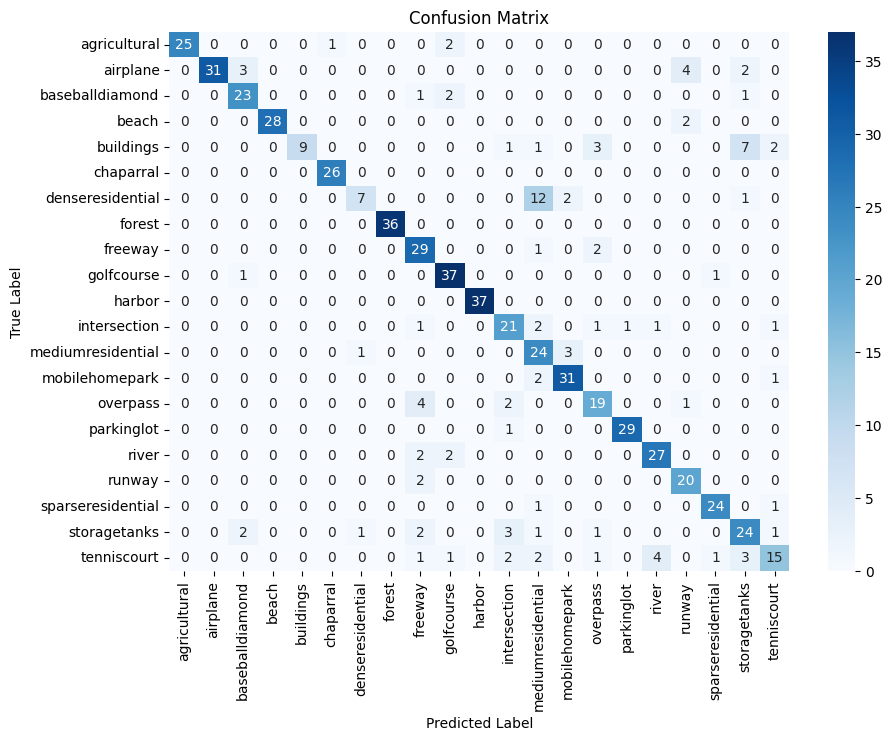

In [7]:
# Main execution

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match VGG-19 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    data_path = r"C:\Users\debli\Downloads\UCMerced_LandUse\UCMerced_LandUse\Images"

    # Get image paths and labels
    print("Step1: Getting the image paths and labels...")
    image_paths, labels, categories, label_encoder = get_image_paths_and_labels(data_path)

    # Split data into training and test sets (70% train, 30% test)
    print("Step2: Splitting the images and labels into training and test datasets...")
    features_train, features_test, labels_train, labels_test = train_test_split(image_paths, labels, test_size=0.3, random_state=101)

    # Load dataset
    print("Step3: Initiating custom dataset class for both traing and testing dataset...")
    train_dataset = CustomImageDataset(features_train, labels_train, transform=transform)
    test_dataset = CustomImageDataset(features_test, labels_test, transform=transform)
    
    print("Step4: Initiating dataloader for both traing and testing dataset...")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model
    print("Step5: The GoogleNet model is being initiated...")
    model = InceptionNet(in_channels = 3, num_classes = 21, dropout_rate = 0.4).to(device)

    # Define loss function & optimizer
    print("Step6: Defining loss function and optimizer...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train and evaluate model
    print("Step7: The model traing started...")
    train_model(model, train_loader, criterion, optimizer, device, epochs=15)
    print("Step8: Model is being evaluated on the test dataset...")
    evaluate_model(model, test_loader, criterion, device, categories)
